In this file we explore the dataset without any alteration

# Imports and Configurations

In [23]:
import torch
import torchvision
import torchvision.transforms as transforms

import torchinfo

import matplotlib.pyplot as plt
import numpy as np
import time

import os
import pathlib
from PIL import Image
import skimage
from tqdm import tqdm

# importing a module with utilities for displaying stats and data
import sys
sys.path.insert(1, '../util')
import vcpi_util

In [24]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [25]:
# Paths
pathTrain = '../train_images/GTSRB/Final_Training/Images'
pathTest = '../test_images'

# Batch size - It can influence speed and generalization, not necessarily in the same direction. 
# There is no golden rule for the batch size but 32 is a commom number to start with.
BATCH_SIZE = 32

IMAGE_SIZE = 32
EPOCHS = 20

# Auxiliary Functions

In [26]:
def evaluate(model, data_loader):

    # sets the model in evaluation mode.
    # although our model does not have layers which behave differently during training and evaluation
    # this is a good practice as the models architecture may change in the future
    model.eval()

    correct = 0
    
    for i, (images, targets) in enumerate(data_loader):
         
        # forward pass, compute the output of the model for the current batch
        outputs = model(images.to(device))

        # "max" returns a namedtuple (values, indices) where values is the maximum 
        # value of each row of the input tensor in the given dimension dim; 
        # indices is the index location of each maximum value found (argmax).
        # the argmax effectively provides the predicted class number        
        _, preds = torch.max(outputs, dim=1)

        correct += (preds.cpu() == targets).sum()

    return (correct / len(data_loader.dataset)).item()

# Prepare and Load Data

In [27]:
# Convert the images from ppm to png
from PIL import Image
import glob
def ppm2png():
    images = glob.glob(f'{pathTrain}/**/*.ppm',recursive=True)
    for image in images:
        im = Image.open(image)
        new_filename = image[:-4] + '.png'
        im.save(new_filename)
        if image.endswith('.ppm'):
            os.remove(image)

    images = glob.glob(f'{pathTest}/**/*.ppm',recursive=True)
    for image in images:
        im = Image.open(image)
        new_filename = image[:-4] + '.png'
        im.save(new_filename)
        if image.endswith('.ppm'):
            os.remove(image)
#ppm2png()

In [28]:
transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),transforms.ToTensor()])

In [29]:
train_set = torchvision.datasets.ImageFolder(root=pathTrain, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

test_set = torchvision.datasets.ImageFolder(root=pathTest, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE)

In [30]:
train_set.classes

['00000',
 '00001',
 '00002',
 '00003',
 '00004',
 '00005',
 '00006',
 '00007',
 '00008',
 '00009',
 '00010',
 '00011',
 '00012',
 '00013',
 '00014',
 '00015',
 '00016',
 '00017',
 '00018',
 '00019',
 '00020',
 '00021',
 '00022',
 '00023',
 '00024',
 '00025',
 '00026',
 '00027',
 '00028',
 '00029',
 '00030',
 '00031',
 '00032',
 '00033',
 '00034',
 '00035',
 '00036',
 '00037',
 '00038',
 '00039',
 '00040',
 '00041',
 '00042']

In [31]:
test_set.classes

['00000',
 '00001',
 '00002',
 '00003',
 '00004',
 '00005',
 '00006',
 '00007',
 '00008',
 '00009',
 '00010',
 '00011',
 '00012',
 '00013',
 '00014',
 '00015',
 '00016',
 '00017',
 '00018',
 '00019',
 '00020',
 '00021',
 '00022',
 '00023',
 '00024',
 '00025',
 '00026',
 '00027',
 '00028',
 '00029',
 '00030',
 '00031',
 '00032',
 '00033',
 '00034',
 '00035',
 '00036',
 '00037',
 '00038',
 '00039',
 '00040',
 '00041',
 '00042']

In [32]:
# Print the number of images in each class of the training set
for i, c in enumerate(train_set.classes):
    print(f'{c}: {len(os.listdir(os.path.join(pathTrain, c)))}')
print(f'Total: {len(train_set)}')

00000: 211
00001: 2221
00002: 2251
00003: 1411
00004: 1981
00005: 1861
00006: 421
00007: 1441
00008: 1411
00009: 1471
00010: 2011
00011: 1321
00012: 2101
00013: 2161
00014: 781
00015: 631
00016: 421
00017: 1111
00018: 1201
00019: 211
00020: 361
00021: 331
00022: 391
00023: 511
00024: 271
00025: 1501
00026: 601
00027: 241
00028: 541
00029: 271
00030: 451
00031: 781
00032: 241
00033: 690
00034: 421
00035: 1201
00036: 391
00037: 211
00038: 2071
00039: 301
00040: 361
00041: 241
00042: 241
Total: 39209


In [33]:
# Print the number of images in each class of the test set
for i, c in enumerate(test_set.classes):
    print(f'{c}: {len(os.listdir(os.path.join(pathTest, c)))}')
print(f'Total: {len(test_set)}')

00000: 60
00001: 720
00002: 750
00003: 450
00004: 660
00005: 630
00006: 150
00007: 450
00008: 450
00009: 480
00010: 660
00011: 420
00012: 690
00013: 720
00014: 270
00015: 210
00016: 150
00017: 360
00018: 390
00019: 60
00020: 90
00021: 90
00022: 120
00023: 150
00024: 90
00025: 480
00026: 180
00027: 60
00028: 150
00029: 90
00030: 150
00031: 270
00032: 60
00033: 210
00034: 120
00035: 390
00036: 120
00037: 60
00038: 690
00039: 90
00040: 90
00041: 60
00042: 90
Total: 12630


In [34]:
images, targets = next(iter(train_loader))
print("Batch shape: ", images.shape) # [batch_size, channels, height, width]
print(targets) 

Batch shape:  torch.Size([32, 3, 32, 32])
tensor([ 1, 26, 35,  8, 28,  5,  6, 29,  4, 37,  3, 10,  7,  4,  1, 38, 20,  1,
        10,  3, 17,  9, 42,  8,  3,  3, 30, 12,  4,  1, 18, 25])


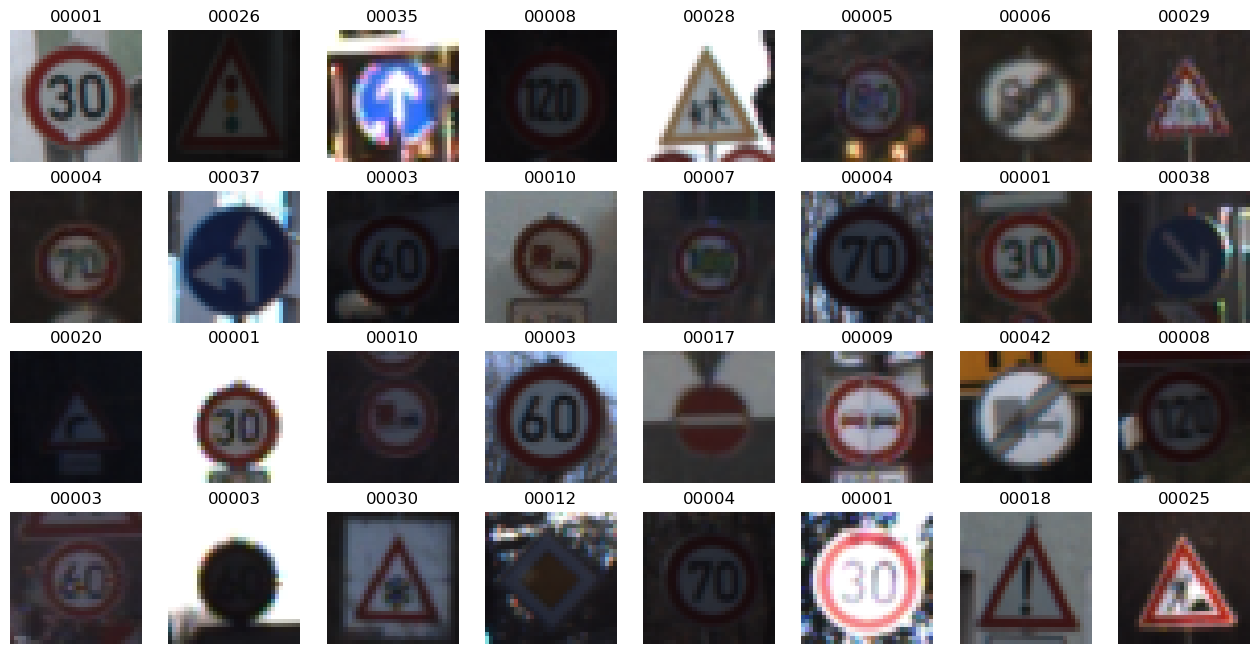

<Figure size 640x480 with 0 Axes>

In [35]:
vcpi_util.show_images(4,8,images, targets, train_set.classes)

# Treino

In [36]:
class Conv(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.conv1 = torch.nn.Conv2d(3, 128, 3) 
        self.bn1 = torch.nn.BatchNorm2d(128)    
        self.relu1 = torch.nn.ReLU()
        self.drop1 = torch.nn.Dropout2d(0.3)

        self.conv2 = torch.nn.Conv2d(128, 256, 3)
        self.bn2 = torch.nn.BatchNorm2d(256)
        self.relu2 = torch.nn.ReLU()
        self.drop2 = torch.nn.Dropout2d(0.3)

        self.maxpool1 = torch.nn.MaxPool2d(2)

        self.conv3 = torch.nn.Conv2d(256, 512, 3)
        self.bn3 = torch.nn.BatchNorm2d(512)        
        self.relu3 = torch.nn.ReLU()
        self.drop3 = torch.nn.Dropout2d(0.3)

        self.conv4 = torch.nn.Conv2d(512, 512, 3)
        self.bn4 = torch.nn.BatchNorm2d(512)
        self.relu4 = torch.nn.ReLU()
        self.drop4 = torch.nn.Dropout2d(0.3)

        self.maxpool2 = torch.nn.MaxPool2d(2)

        self.fc1 = torch.nn.Linear(12800, num_classes) 

    def forward(self, x):
        # input = (batch_size, 3, 32, 32)
        x = self.conv1(x)                  # output = (batch_size, 128, 30, 30) 
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.drop1(x)

        x = self.conv2(x)                  # output = (batch_size, 256, 28, 28)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.drop2(x)

        x = self.maxpool1(x)               # output = (batch_size, 256, 14, 14)

        x = self.conv3(x)                  # output = (batch_size, 512, 12, 12)                     
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.drop3(x)

        x = self.conv4(x)                  # output = (batch_size, 512, 10, 10)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.drop4(x)

        x = self.maxpool2(x)               # output = (batch_size, 512, 5, 5)     512 x 5 x 5 = 12800

        x = torch.flatten(x, 1)             
        x = self.fc1(x)                                                                                     

        return x 
    
model_III = Conv(len(train_set.classes))
model_III.to(device)
print(model_III)

torchinfo.summary(model_III, input_size=(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE))

Conv(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (drop1): Dropout2d(p=0.3, inplace=False)
  (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (drop2): Dropout2d(p=0.3, inplace=False)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (drop3): Dropout2d(p=0.3, inplace=False)
  (conv4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (drop4): Dropout2d(p=0.3, inplace=False)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, pa

Layer (type:depth-idx)                   Output Shape              Param #
Conv                                     [32, 43]                  --
├─Conv2d: 1-1                            [32, 128, 30, 30]         3,584
├─BatchNorm2d: 1-2                       [32, 128, 30, 30]         256
├─ReLU: 1-3                              [32, 128, 30, 30]         --
├─Dropout2d: 1-4                         [32, 128, 30, 30]         --
├─Conv2d: 1-5                            [32, 256, 28, 28]         295,168
├─BatchNorm2d: 1-6                       [32, 256, 28, 28]         512
├─ReLU: 1-7                              [32, 256, 28, 28]         --
├─Dropout2d: 1-8                         [32, 256, 28, 28]         --
├─MaxPool2d: 1-9                         [32, 256, 14, 14]         --
├─Conv2d: 1-10                           [32, 512, 12, 12]         1,180,160
├─BatchNorm2d: 1-11                      [32, 512, 12, 12]         1,024
├─ReLU: 1-12                             [32, 512, 12, 12]       

In [37]:
def train(model, train_loader, test_loader,epochs, loss_fn, optimizer):
    history = {}
    history['accuracy'] = []
    history['test_acc'] = []
    history['loss'] = []

    for epoch in range(epochs):
        start_time = time.time()

        correct = 0
        running_loss = 0

        for i, (inputs, targets) in enumerate(train_loader,0): # inputs são as imagens e targets são as classes (128 de cada por ser o batch size)
            # send data to the GPU
            inputs, targets = inputs.to(device), targets.to(device)

            # forward pass, compute the output of the model for the current batch
            outputs = model(inputs)

            # calcula o maximo dos outputs na dimensao 1 e devolve o maximo e o seu indice(indice da classe)
            _, predicted = torch.max(outputs, 1)             

            #compute the loss between the model's outputs and the labels, or targets.
            loss = loss_fn(outputs, targets)

            # os gradientes de cada iteração são zerados para que não passem para a próxima iteração
            optimizer.zero_grad()                            

            # perform backpropagation
            loss.backward()


            #update the model's parameters
            optimizer.step()

            running_loss += loss
            correct += (predicted == targets).sum()

        model.eval()
        t_correct = 0

        with torch.no_grad():    
            for i,t in test_loader:
                i, t = i.to(device), t.to(device)
                o = model(i)
                _, p = torch.max(o, 1)

                t_correct += (p == t).sum()

        epoch_loss = running_loss / len(train_loader.dataset)
        accuracy = 100 * correct / len(train_loader.dataset)
        t_accuracy = 100 * t_correct / len(test_loader.dataset)
        stop_time = time.time()
        print(f'Epoch {epoch:03d}; Loss: {epoch_loss:0.4f}; Accuracy: {accuracy:0.4f}; Accuracy_Test: {t_accuracy:0.4f} ; Time: {(stop_time - start_time):0.4f}')
        
        history['accuracy'].append(accuracy.cpu().numpy())
        history['test_acc'].append(t_accuracy.cpu().numpy())
        history['loss'].append(running_loss.cpu().detach().numpy())

    print('Finished Training')

    return history
            

In [38]:
optimizer_III = torch.optim.Adam(model_III.parameters())
loss_fn = torch.nn.CrossEntropyLoss()

history_III = train(model_III,train_loader,test_loader,EPOCHS,loss_fn,optimizer_III)

Epoch 000; Loss: 0.0366; Accuracy: 74.2355; Accuracy_Test: 93.2621 ; Time: 64.4668
Epoch 001; Loss: 0.0016; Accuracy: 98.7299; Accuracy_Test: 94.7189 ; Time: 62.2057
Epoch 002; Loss: 0.0010; Accuracy: 99.0665; Accuracy_Test: 96.1362 ; Time: 59.9977
Epoch 003; Loss: 0.0009; Accuracy: 99.2553; Accuracy_Test: 96.6033 ; Time: 59.6081
Epoch 004; Loss: 0.0008; Accuracy: 99.3037; Accuracy_Test: 95.4236 ; Time: 61.0148
Epoch 005; Loss: 0.0005; Accuracy: 99.5537; Accuracy_Test: 95.5344 ; Time: 61.1897
Epoch 006; Loss: 0.0005; Accuracy: 99.5945; Accuracy_Test: 96.7221 ; Time: 61.1655
Epoch 007; Loss: 0.0003; Accuracy: 99.7348; Accuracy_Test: 96.6350 ; Time: 61.6608
Epoch 008; Loss: 0.0004; Accuracy: 99.6659; Accuracy_Test: 96.5796 ; Time: 62.2263
Epoch 009; Loss: 0.0003; Accuracy: 99.7985; Accuracy_Test: 97.2526 ; Time: 61.6463
Epoch 010; Loss: 0.0004; Accuracy: 99.6863; Accuracy_Test: 97.0150 ; Time: 61.5404
Epoch 011; Loss: 0.0001; Accuracy: 99.9158; Accuracy_Test: 96.7063 ; Time: 61.0625
Epoc

# Análise dos Resultados

Although it may coincide, the best epoch considering training data accuracy is not always the best epoch for test data accuracy

In [39]:
best_train = np.asarray(history_III['accuracy']).argmax()
best_test = np.asarray(history_III['test_acc']).argmax()

print('Best epoch for train accuracy:', best_train,' Best epoch for test accuracy:',  best_test)
print('Test accuracy at epoch ',best_train, ' :', history_III['test_acc'][best_train], 'Test accuracy at epoch ',best_test, ' :', history_III['test_acc'][best_test])

Best epoch for train accuracy: 14  Best epoch for test accuracy: 16
Test accuracy at epoch  14  : 97.79097 Test accuracy at epoch  16  : 98.14727


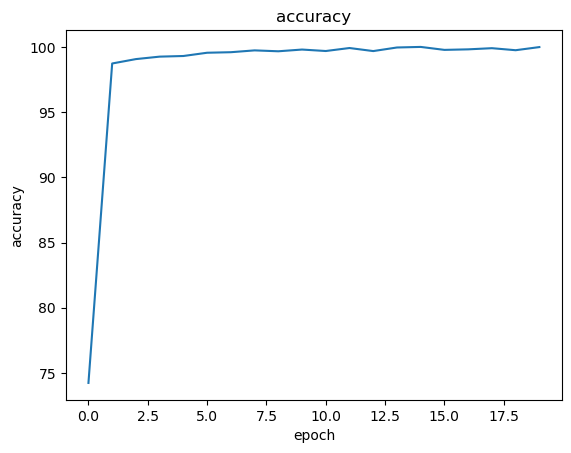

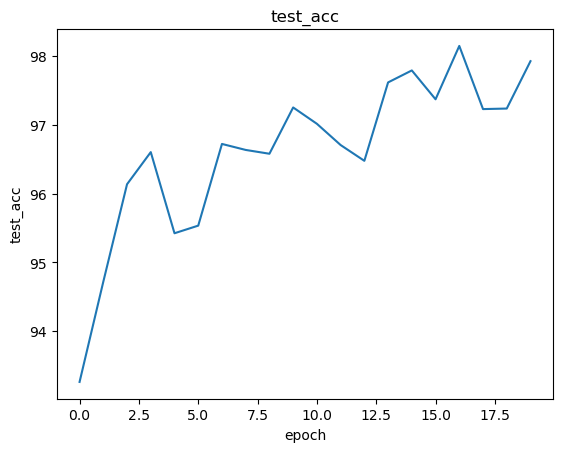

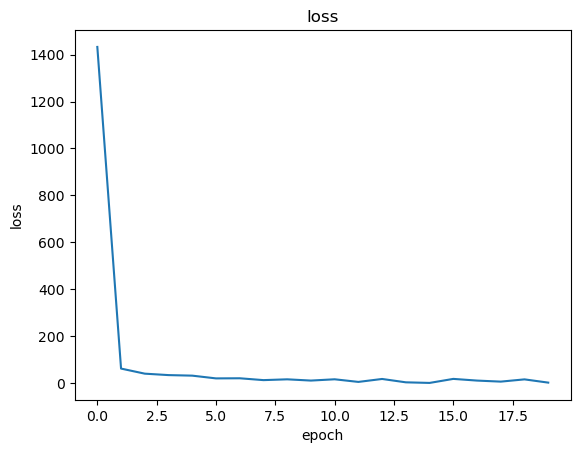

In [40]:
vcpi_util.show_history(history_III)

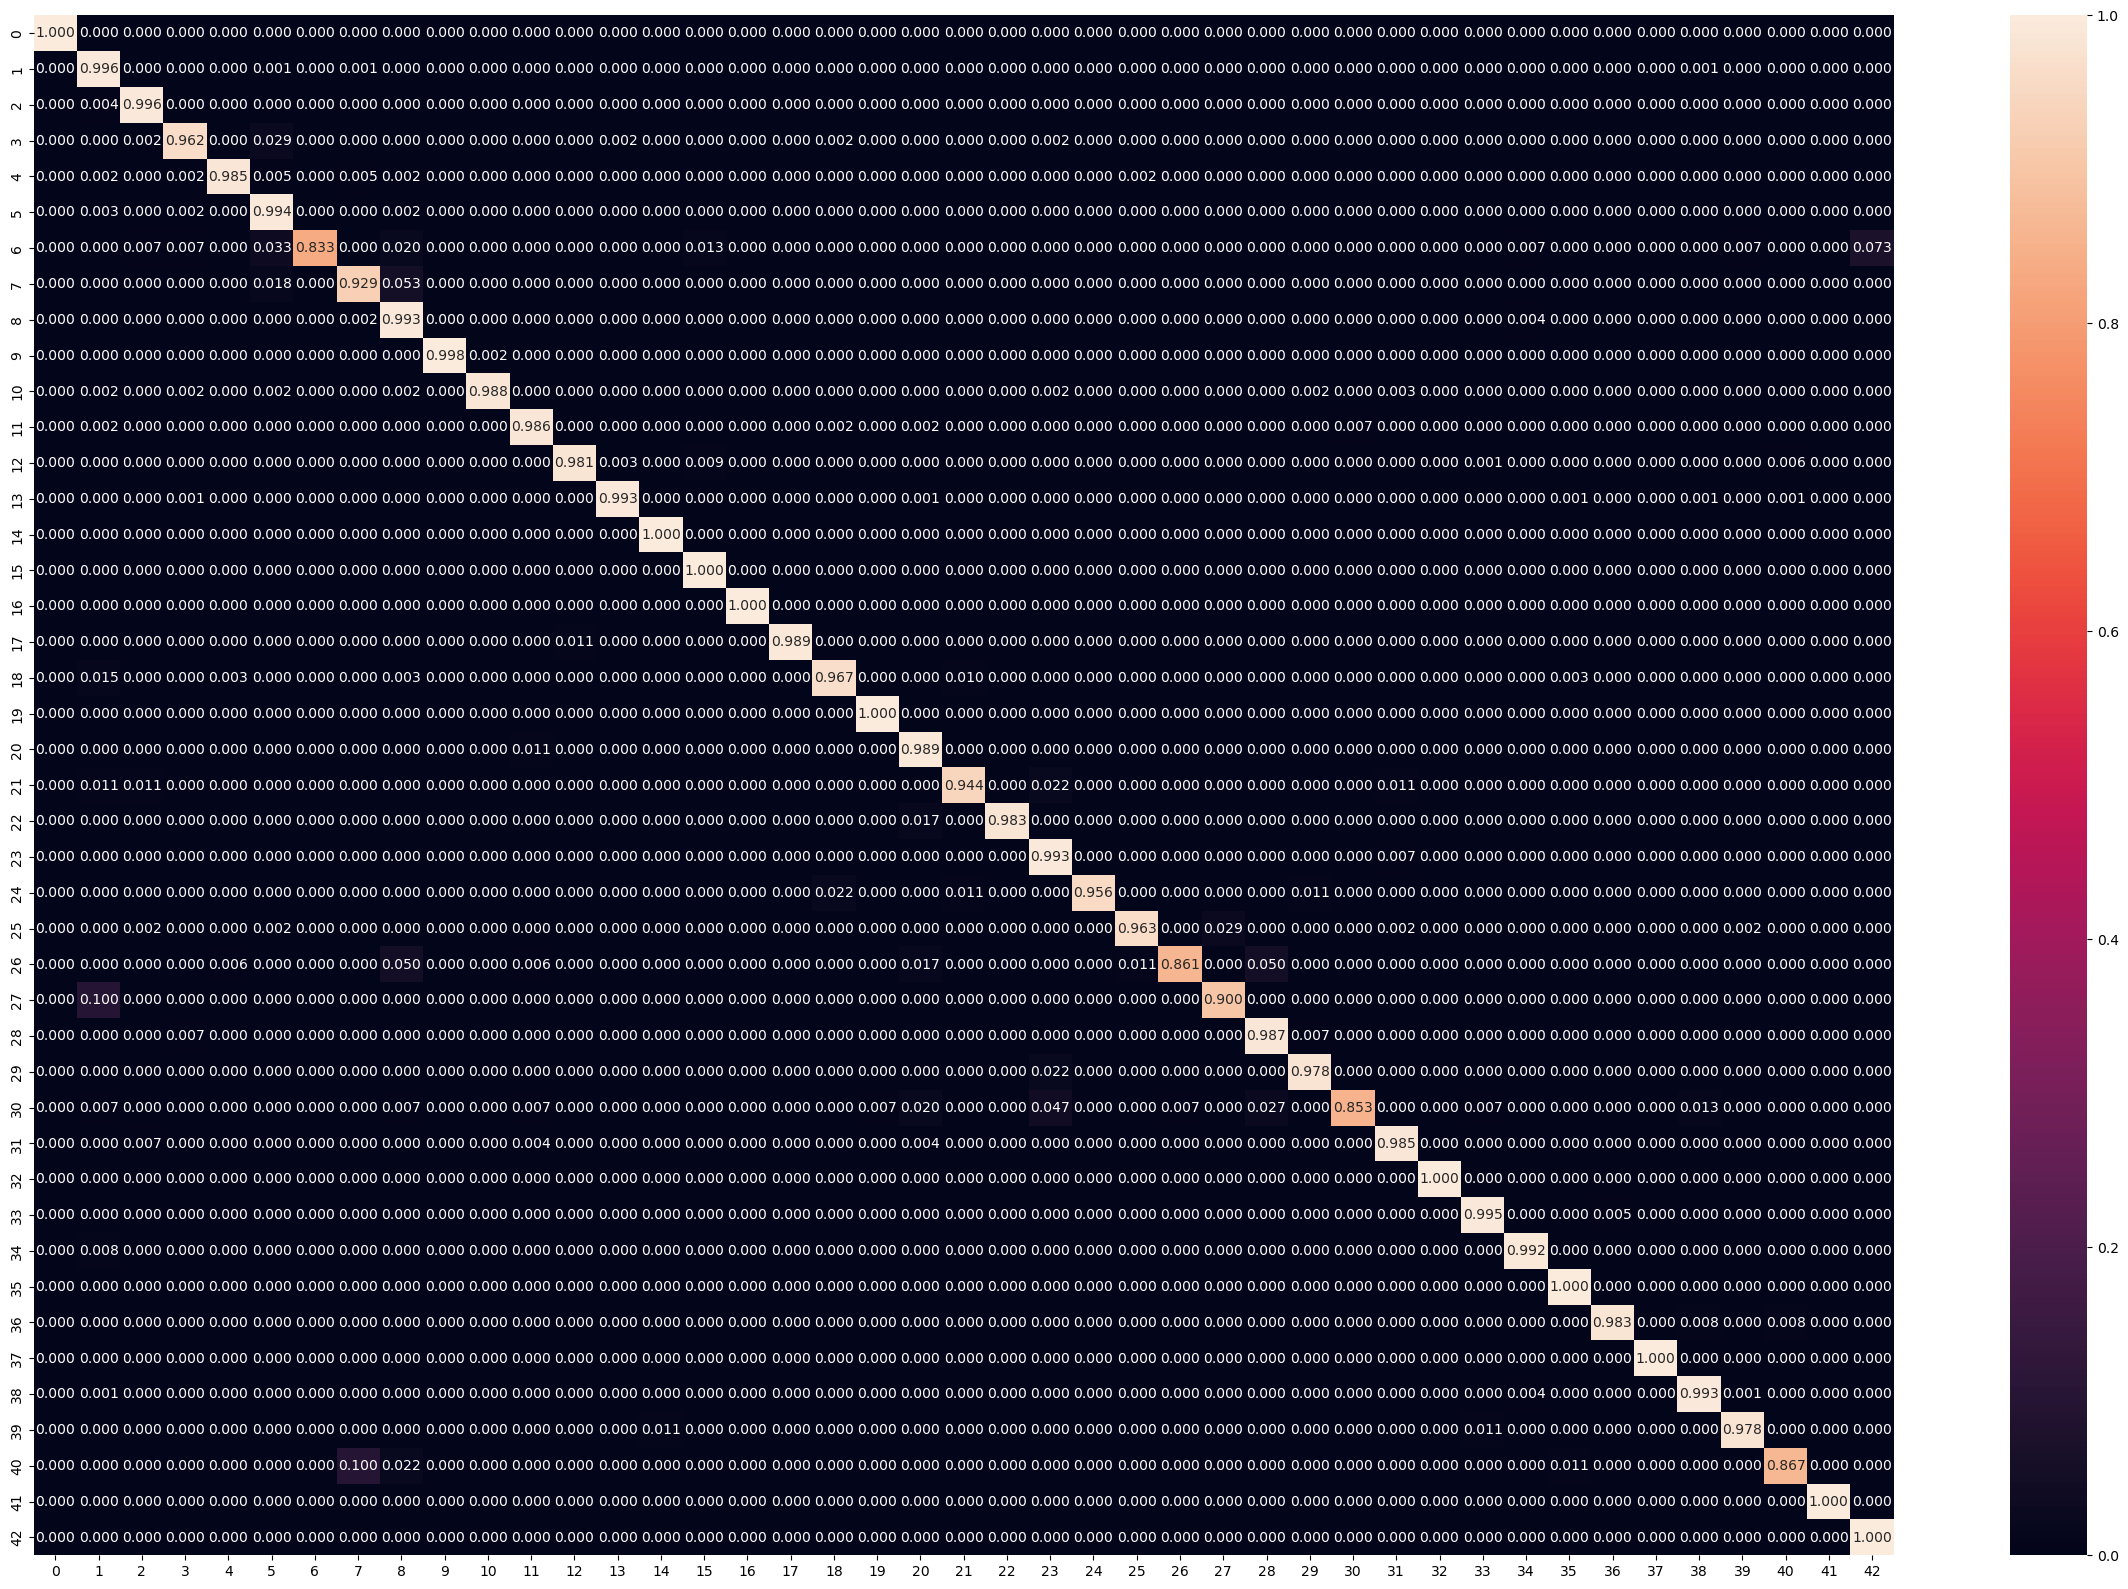

In [41]:
preds = []
ground_truth = []

for images, targets in test_loader:
    logits = model_III(images.to(device))
    preds_aux = [np.argmax(x) for x in logits.cpu().detach().numpy()]
    preds.extend(preds_aux) 
    ground_truth.extend(targets.numpy())

vcpi_util.show_confusion_matrix(ground_truth, preds, len(train_set.class_to_idx))

- From the confusion matrix, built from the predictions on the test set, we can see that regarding accuracy, not all classes behave the same way.
- The histogram presented below shows that the classes 0 are severely under represented, so that might justify its bad performance.

Counter({2: 2250, 1: 2220, 13: 2160, 12: 2100, 38: 2070, 10: 2010, 4: 1980, 5: 1860, 25: 1500, 9: 1470, 7: 1440, 8: 1410, 3: 1410, 11: 1320, 18: 1200, 35: 1200, 17: 1110, 14: 780, 31: 780, 33: 689, 15: 630, 26: 600, 28: 540, 23: 510, 30: 450, 6: 420, 16: 420, 34: 420, 36: 390, 22: 390, 40: 360, 20: 360, 21: 330, 39: 300, 29: 270, 24: 270, 27: 240, 42: 240, 32: 240, 41: 240, 37: 210, 0: 210, 19: 210})


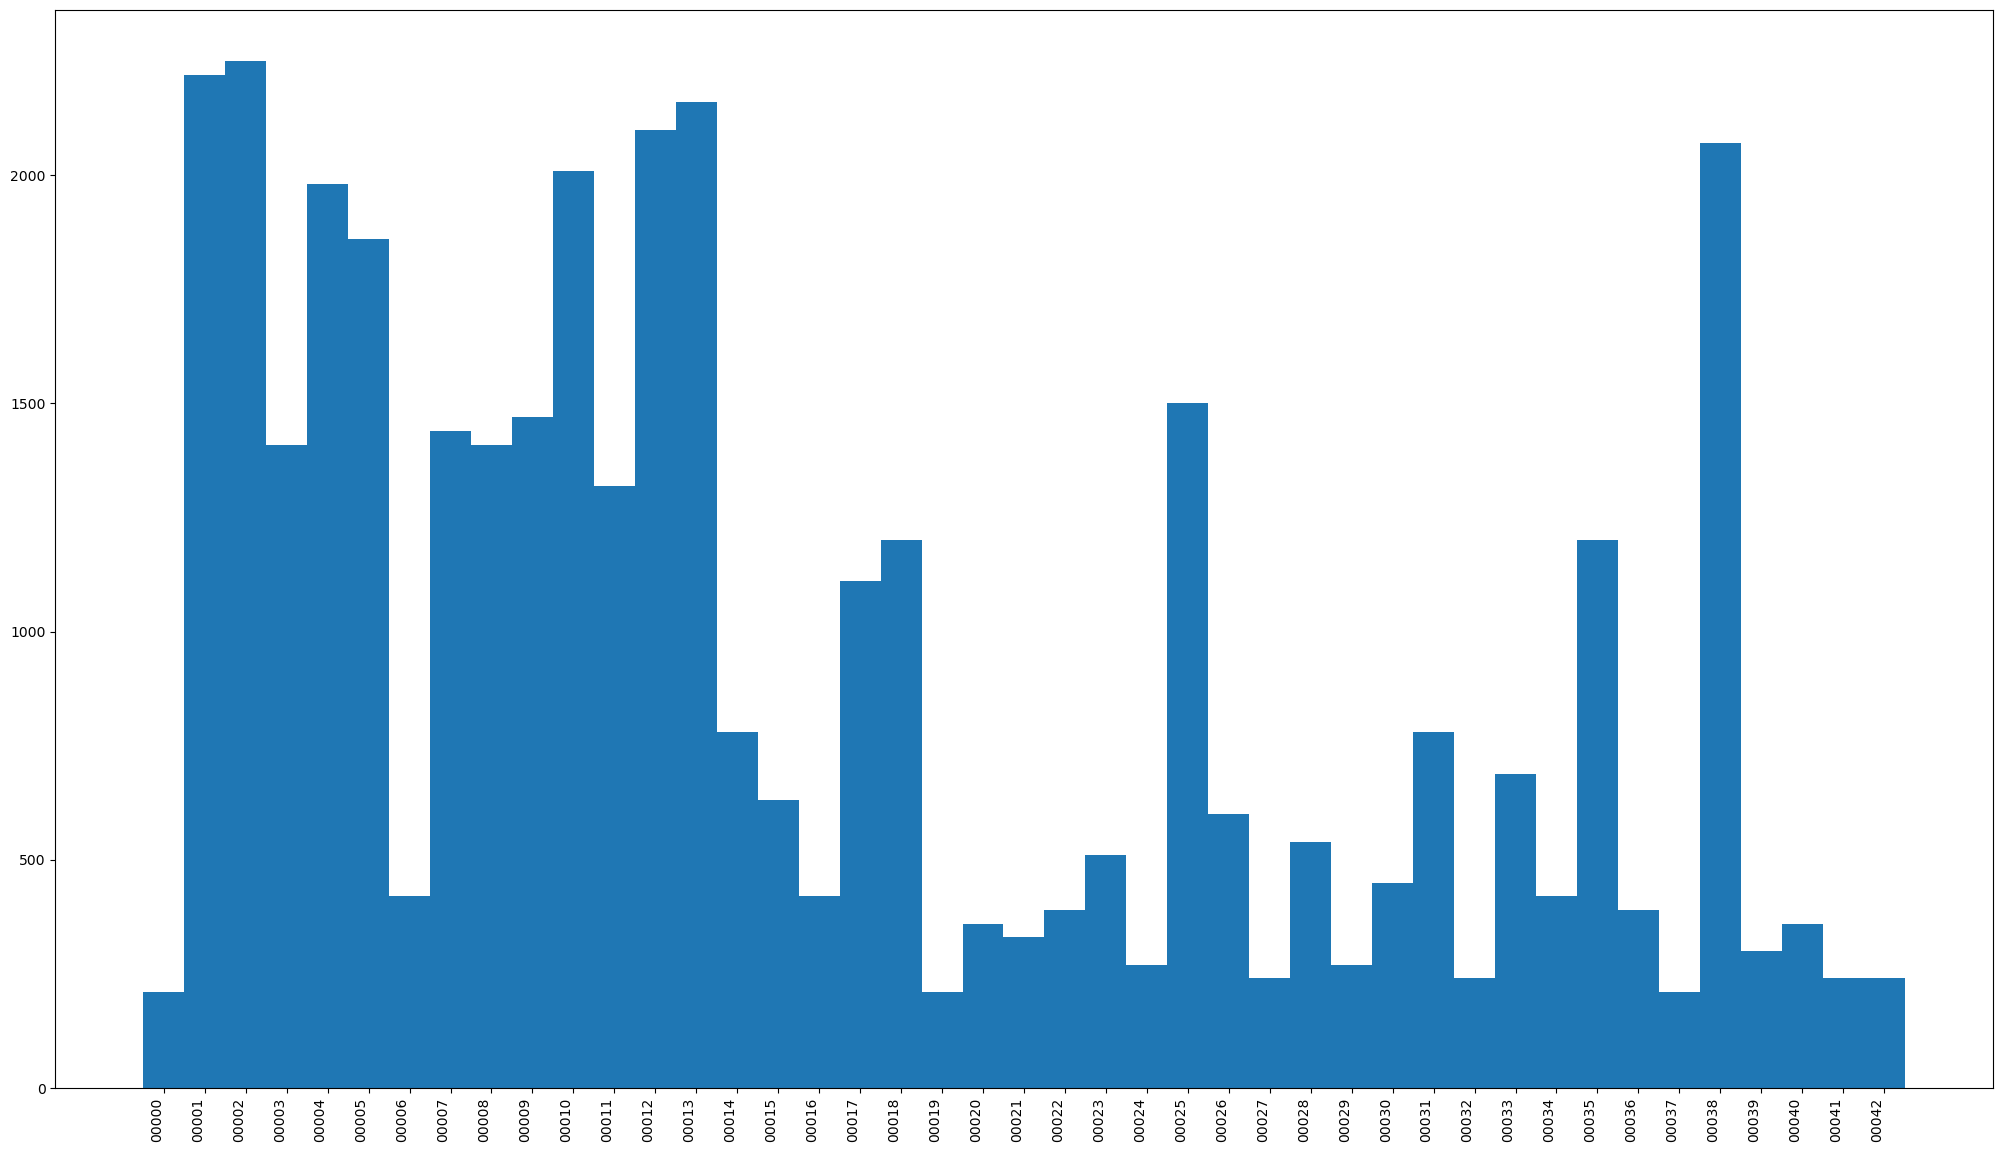

In [42]:
target_list = []

for images, targets in train_loader:
    target_list.extend(targets)

vcpi_util.show_histogram(target_list,train_set.classes)

In [43]:
def show_bad_preds(model, dataset, classes):
    k = 0
    iters = 0

    preds = []
    ground_truth = []
    imgs = torch.Tensor(BATCH_SIZE, 3, IMAGE_SIZE,IMAGE_SIZE)

    iterator = iter(dataset)

    max_iters = test_set.__len__() / BATCH_SIZE
    while k < 32 and iters < max_iters:

        images, targets = next(iterator)
        #print(images[0].shape)
        logits = model(images.to(device))
        
        #print(predictions[0])
        predictions = torch.nn.functional.softmax(logits, dim=1).cpu().detach().numpy()
        for i in range(len(predictions)):

            if np.argmax(predictions[i]) != targets[i] and k < 32:

                preds.append(predictions[i])
                ground_truth.append(targets[i])
                imgs[k, :, :, :] = images[i]
                k += 1

        iters += 1

    vcpi_util.plot_predictions(imgs, preds, ground_truth, classes, 10, 3)

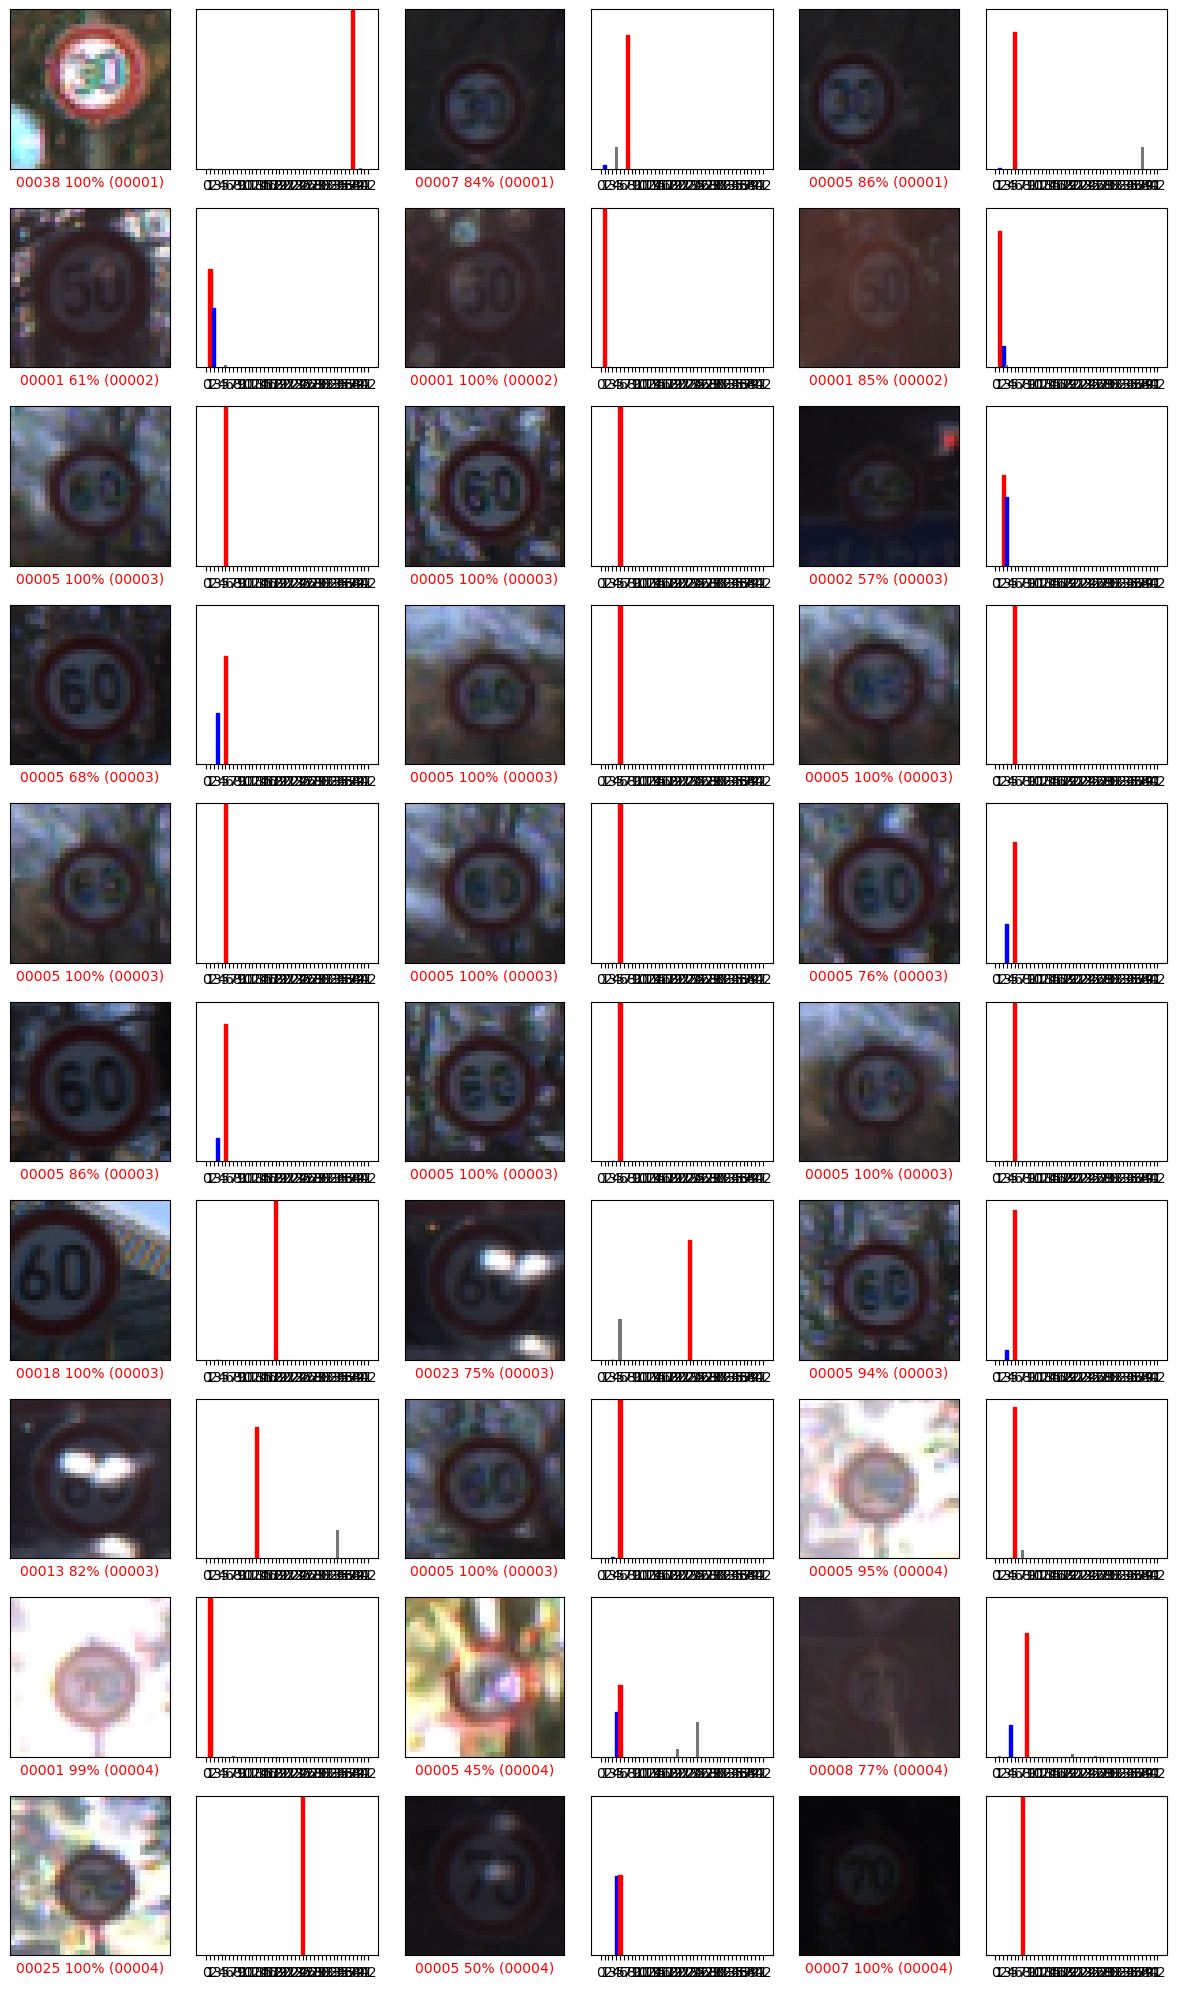

In [44]:
show_bad_preds(model_III, test_loader, test_set.classes)